https://wikidocs.net/129746#_5

In [1]:
import os
import time
import ccxt
import csv
import re
import pandas as pd

In [3]:
with open("api.txt") as f:
    lines = f.readlines()
    api_key = lines[0].strip()
    secret  = lines[1].strip()

binance = ccxt.binance(config={
    'rateLimit': 1000,
    'apiKey': api_key, 
    'secret': secret,
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future'
    }
})

In [1]:
def bring_price_data(coin, period, start_date=None):
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    day = 24 * hour
    hold = 30
    
    if period == '1m':
        interval = minute
    elif period == '1h':
        interval = hour
    elif period == '1d':
        interval = day
    
    coin = coin.upper()

    os.makedirs('{}_price_data'.format(period), exist_ok=True)
    filepath_ = os.getcwd() + '/{}_price_data/'.format(period)
    
    secondary_file = False
    
    if start_date:
        from_timestamp = binance.parse8601(start_date)
    
    if '{}.csv'.format(coin) in os.listdir(filepath_): # 이미 앞서 저장한 데이터가 있는 경우
        with open(filepath_ + '{}.csv'.format(coin), 'r', newline='', encoding='cp949') as csv_file:
            reader = list(csv.reader(csv_file, delimiter=',', quotechar='"'))
            csv_file.close()
            
            if start_date == None: # 시작 날짜가 정해져 있지 않으면 저장되어 있는 마지막 시간 이후부터 이어서 데이터를 저장
                from_timestamp = int(reader[-1][0]) + interval
                
            elif int(reader[1][0]) <= from_timestamp <= int(reader[-1][0]): # 시작 날짜가 기존 데이터에 포함되어 있는 경우 마지막 시간 이후부터 이어서 데이터를 저장
                from_timestamp = int(reader[-1][0]) + interval
                
            else: # 그 이외의 경우 새로운 csv 파일 생성
                secondary_file = True
                
    elif '{}.csv'.format(coin) not in os.listdir(filepath_) and start_date == None: # 기존 파일없는데 시작 날짜 지정도 안했으면 에러
        raise DateError('Plese enter start_date.')
            
            
    now = binance.milliseconds()
    data = []
    
    print('Start timestamp is ', binance.iso8601(from_timestamp))
    while from_timestamp < now:
        try:
            ohlcvs = binance.fetch_ohlcv('{}/USDT'.format(coin), period, from_timestamp) # 분봉 데이터 로드
            print('Fetched', len(ohlcvs))
            from_timestamp += len(ohlcvs) * interval
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error: # 오류나면 30초 쉬었다가 다시
            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    print('End timestamp is {}({})'.format(binance.iso8601(binance.milliseconds()), binance.milliseconds()))
    
    header = ['timestamp', 'open', 'high', 'low', 'close', 'vol']
    data = pd.DataFrame(data, columns=header)
    if '{}.csv'.format(coin) in os.listdir(filepath_) and secondary_file == False:
        print('Already price data file exist, appending new data at same file...')
        data.to_csv(filepath_ + '{}.csv'.format(coin), mode='a', header=False, index=False)
        
    elif '{}.csv'.format(coin) in os.listdir(filepath_) and secondary_file == True:
        print('Already price data file exist, making secondary file...')
        filelist_ = os.listdir(filepath_+'/')
        matching = sorted([filename for filename in filelist_ if coin in filename])
        if len(matching) == 1:
            n = 2
        else:
            n = int(re.findall(r'\d+', matching[-1])[0]) + 1
        data.to_csv(filepath_ + '{}_{}.csv'.format(coin, n), mode='w', header=header, index=False)
        
    else:
        data.to_csv(filepath_ + '{}.csv'.format(coin), mode='w', header=header, index=False)

In [15]:
coins = ['BTC', 'BNB', 'SOL', 'ETH', 'XRP', 'ADA', 'LUNA']
for coin in coins:
    bring_price_data(coin)

Start timestamp is  2022-04-12T06:02:00.000Z
Fetched 280
End timestamp is 2022-04-12T10:41:17.651Z(1649760077651)
Already price data file exist, appending new data at same file...
Start timestamp is  2022-04-12T06:34:00.000Z
Fetched 248
End timestamp is 2022-04-12T10:41:22.590Z(1649760082590)
Already price data file exist, appending new data at same file...
Start timestamp is  2022-04-12T07:01:00.000Z
Fetched 221
End timestamp is 2022-04-12T10:41:27.594Z(1649760087594)
Already price data file exist, appending new data at same file...
Start timestamp is  2022-04-12T07:26:00.000Z
Fetched 196
End timestamp is 2022-04-12T10:41:32.642Z(1649760092642)
Already price data file exist, appending new data at same file...
Start timestamp is  2022-04-12T08:02:00.000Z
Fetched 160
End timestamp is 2022-04-12T10:41:37.595Z(1649760097595)
Already price data file exist, appending new data at same file...
Start timestamp is  2022-04-12T09:20:00.000Z
Fetched 82
End timestamp is 2022-04-12T10:41:42.598Z(16

In [57]:
data = pd.read_csv('price_data/LUNA.csv')

In [52]:
data

,timestamp,open,high,low,close,vol
0,1640995200000,85.479,85.747,85.464,85.648,5464.0
1,1640995260000,85.652,85.801,85.509,85.795,6731.0
2,1640995320000,85.754,85.816,85.660,85.788,3470.0
3,1640995380000,85.789,85.793,85.622,85.653,5637.0
4,1640995440000,85.653,85.653,85.492,85.519,3967.0
...,...,...,...,...,...,...
146077,1649759820000,84.849,84.871,84.705,84.717,5699.0
146078,1649759880000,84.720,84.766,84.699,84.738,1206.0
146079,1649759940000,84.742,84.915,84.738,84.874,5587.0
146080,1649760000000,84.874,84.883,84.761,84.768,1861.0


In [56]:
data2 = pd.read_csv('price_data/BTC.csv')

In [60]:
import matplotlib.pyplot as plt

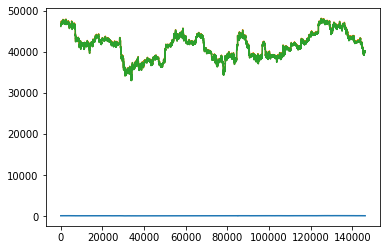

In [63]:
plt.plot(data['close'])
plt.plot(data2['close'])
plt.plot(data2['close'] - data['close'])

In [22]:
import numpy as np

In [4]:
binance.parse8601('2022-04-01 00:00:00')

1648771200000

In [7]:
btc = pd.read_csv('price_data/BTC.csv')
bnb = pd.read_csv('price_data/BNB.csv')
sol = pd.read_csv('price_data/SOL.csv')
eth = pd.read_csv('price_data/ETH.csv')
xrp = pd.read_csv('price_data/XRP.csv')
ada = pd.read_csv('price_data/ADA.csv')
luna = pd.read_csv('price_data/LUNA.csv')
data_list = [btc, bnb, sol, eth, xrp, ada, luna]

In [10]:
btc.timestamp

0         1640995200000
1         1640995260000
2         1640995320000
3         1640995380000
4         1640995440000
              ...      
146077    1649759820000
146078    1649759880000
146079    1649759940000
146080    1649760000000
146081    1649760060000
Name: timestamp, Length: 146082, dtype: int64

In [11]:
coins = ['btc', 'bnb', 'sol', 'eth', 'xrp', 'ada', 'luna']
merge_df = pd.concat([x.close for x in data_list], axis=1)
merge_df.columns = coins
merge_df['timestamp'] = btc.timestamp

In [16]:
merge_df[merge_df['timestamp'] == 1648771200000]

,btc,bnb,sol,eth,xrp,ada,luna,timestamp
129600,45455.4,428.5,122.76,3279.28,0.8147,1.1406,102.866,1648771200000


In [24]:
ap_df = merge_df.iloc[129600:]
ap_df.drop('timestamp', axis=1, inplace=True)

/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [29]:
(ap_df / ap_df.shift(1)).dropna().corr().style.background_gradient(cmap='summer_r')

,btc,bnb,sol,eth,xrp,ada,luna
btc,1.000000,0.825395,0.734218,0.849514,0.760093,0.782946,0.658711
bnb,0.825395,1.000000,0.771057,0.838721,0.766144,0.797150,0.679245
sol,0.734218,0.771057,1.000000,0.767415,0.705991,0.754434,0.645085
eth,0.849514,0.838721,0.767415,1.000000,0.759668,0.799074,0.673054
xrp,0.760093,0.766144,0.705991,0.759668,1.000000,0.747296,0.614740
ada,0.782946,0.797150,0.754434,0.799074,0.747296,1.000000,0.652551
luna,0.658711,0.679245,0.645085,0.673054,0.614740,0.652551,1.000000


In [30]:
ap_df

,btc,bnb,sol,eth,xrp,ada,luna
129600,45455.4,428.50,122.76,3279.28,0.8147,1.1406,102.866
129601,45413.9,425.94,122.31,3273.50,0.8131,1.1384,102.759
129602,45555.9,427.52,123.10,3286.31,0.8175,1.1433,103.068
129603,45499.8,427.77,123.03,3280.60,0.8170,1.1422,102.947
129604,45549.2,428.49,123.46,3285.90,0.8185,1.1438,103.057
...,...,...,...,...,...,...,...
146077,40169.7,407.45,102.93,3019.68,0.7059,0.9483,84.717
146078,40191.9,407.57,102.98,3019.89,0.7060,0.9486,84.738
146079,40228.0,407.89,103.00,3023.05,0.7067,0.9497,84.874
146080,40219.5,407.68,102.95,3022.55,0.7067,0.9493,84.768


In [34]:
log_ap_df = np.log(ap_df)
log_price = log_ap_df

In [37]:
from itertools import combinations
from statsmodels.tsa.stattools import coint
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [38]:
def plot_coint_pair_coin(coins):
    n_comb = len(list(combinations(coins, 2)))
    fig, ax = plt.subplots(int(np.ceil(n_comb/2)), 2,
                           figsize=(2 * int(np.ceil(n_comb/2)), 40), constrained_layout=True)
    p_value_list = []
    for idx, (coin1, coin2) in enumerate(combinations(coins, 2)):
        coint_coeff = np.cov(log_price[coin1], log_price[coin2])[0][1] / np.var(log_price[coin2])
        p_value = adfuller(log_price[coin1] - coint_coeff * log_price[coin2])[1]
        p_value_list.append([coin1, coin2, p_value])
        
        ax[idx//2][idx%2].plot(log_price[coin1] - coint_coeff * log_price[coin2])
        ax[idx//2][idx%2].set_title('{}-{} pair(p_value: {})'.format(coin1, coin2, p_value), fontsize=20)
        ax[idx//2][idx%2].axhline((log_price[coin1] - coint_coeff * log_price[coin2]).mean(), color='r', linestyle='--')
    plt.show()
    
    return p_value_list

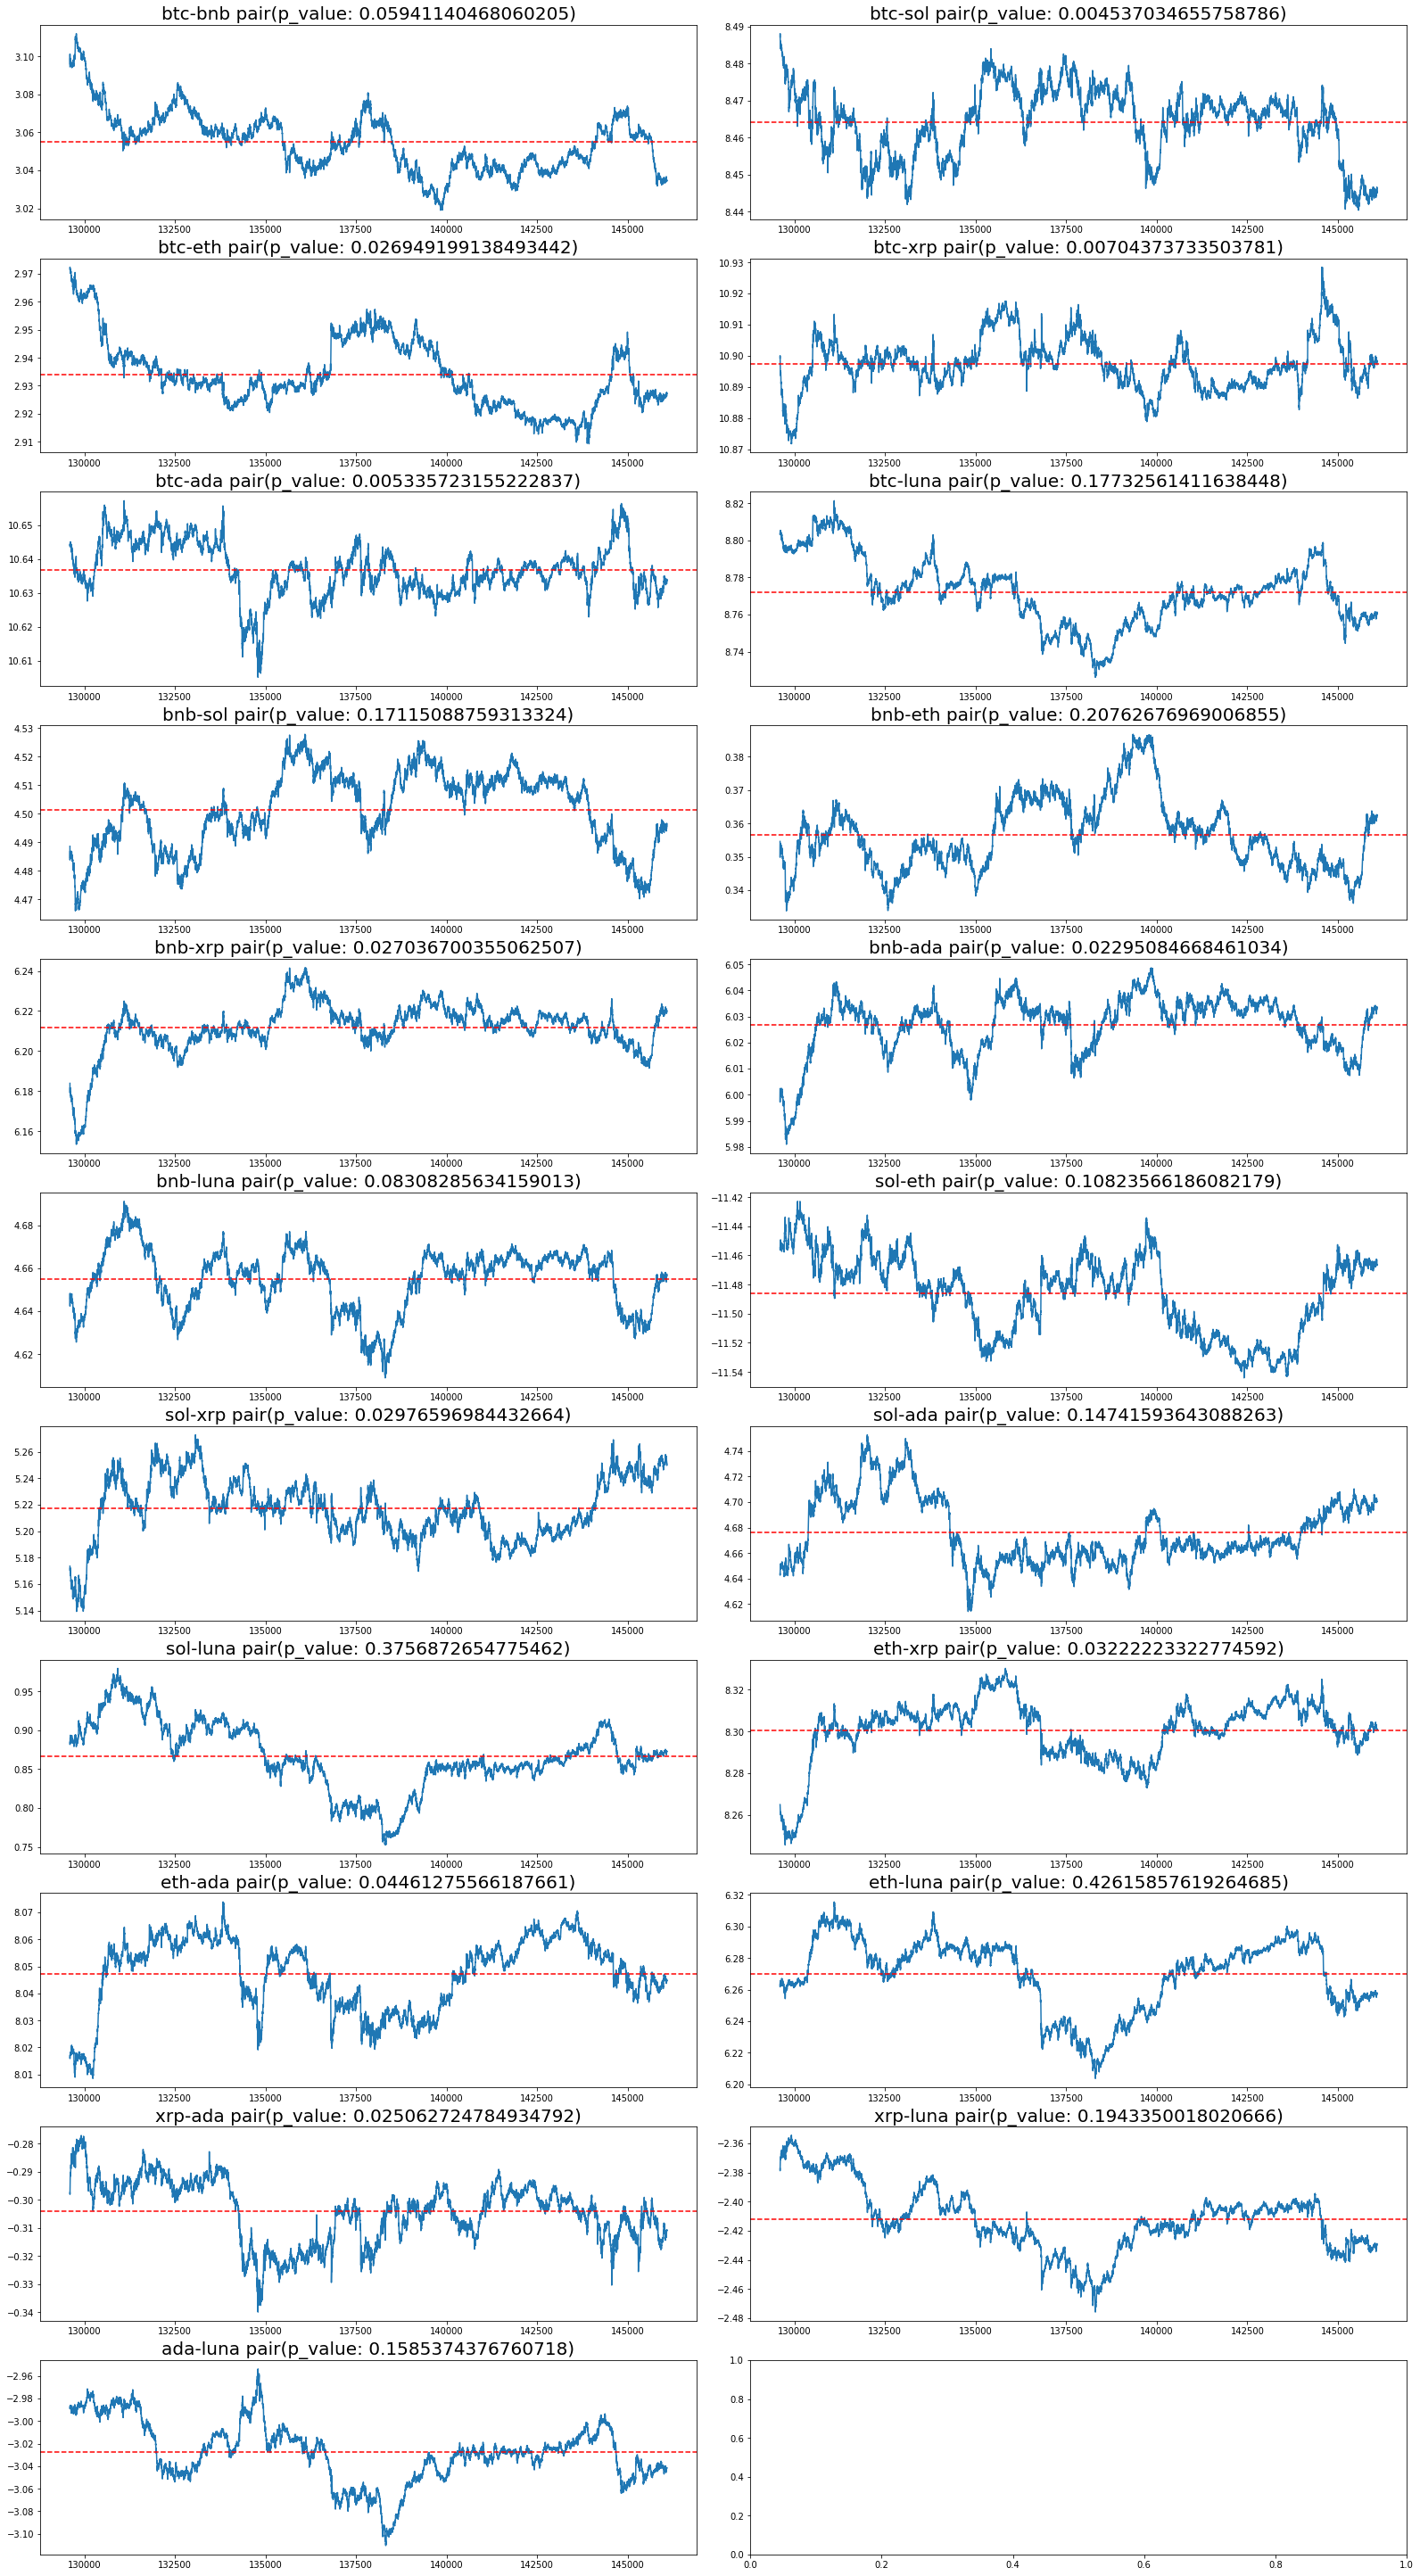

[['btc', 'bnb', 0.05941140468060205],
 ['btc', 'sol', 0.004537034655758786],
 ['btc', 'eth', 0.026949199138493442],
 ['btc', 'xrp', 0.00704373733503781],
 ['btc', 'ada', 0.005335723155222837],
 ['btc', 'luna', 0.17732561411638448],
 ['bnb', 'sol', 0.17115088759313324],
 ['bnb', 'eth', 0.20762676969006855],
 ['bnb', 'xrp', 0.027036700355062507],
 ['bnb', 'ada', 0.02295084668461034],
 ['bnb', 'luna', 0.08308285634159013],
 ['sol', 'eth', 0.10823566186082179],
 ['sol', 'xrp', 0.02976596984432664],
 ['sol', 'ada', 0.14741593643088263],
 ['sol', 'luna', 0.3756872654775462],
 ['eth', 'xrp', 0.03222223322774592],
 ['eth', 'ada', 0.04461275566187661],
 ['eth', 'luna', 0.42615857619264685],
 ['xrp', 'ada', 0.025062724784934792],
 ['xrp', 'luna', 0.1943350018020666],
 ['ada', 'luna', 0.1585374376760718]]

In [39]:
plot_coint_pair_coin(coins)